#Salt Identification Challenge

##Getting the dataset

In [ ]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/93.0.4577.82 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kagglesdsdata/competitions/10151/59042/competition_data.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1633174339&Signature=SVR%2FVKNpVV9twsqY%2FkEtHlDr0h%2F%2F483NW4U4bGZm9m16N2oVI2ktRP6vsplB%2B5V3qdL71J26FTIpkY8ioe4QJ0DxwqScuCghNedkVN9ny%2BWJbUQ4qf%2FacIDuTmV0wRZSUyfyNflwb7HzN6U2QkoorRy0ZzaZNmUup9BNm1MvuTHd%2F4PO04wXVsnrPH%2FeoA7RiLf%2Fl875tQG1Nu7Km3TgN0%2FsKCqmLLALeFTmRjwMXLPJ4urjldccvkorGuH78hhyRsvuwvrUqfWMsM6QU29tFaXGZ1%2FcuAR7HaM2UI1goJGxY8O9bm8FxQhzwvn%2B7L1X7C4FTbZeHngDLqVkgXdG1A%3D%3D&response-content-disposition=attachment%3B+filename%3Dcompetition_data.zip" -c -O 'competition_data.zip'

In [ ]:
!unzip "/content/competition_data.zip" -d "/content/"

In [3]:
import pandas as pd
df = pd.read_csv('/content/competition_data/depths.csv')
df

,id,z
0,4ac19fb269,306
1,1825fadf99,157
2,f59821d067,305
3,5b435fad9d,503
4,e340e7bfca,783
...,...,...
21995,09f1675cfb,400
21996,6947dbc4f4,804
21997,68de95fb39,605
21998,fdad2f99d8,309


In [4]:
import os 
file = os.listdir('/content/competition_data/train/images')
image_path = []
mask_path=[]

for image in file:
  image_path.append('/content/competition_data/train/images/'+image)

file = os.listdir('/content/competition_data/train/masks')
for mask in file:
  mask_path.append('/content/competition_data/train/masks/'+mask)

data_df = pd.DataFrame({'Image' : image_path, 'Mask': mask_path})
data_df

,Image,Mask
0,/content/competition_data/train/images/c98504a...,/content/competition_data/train/masks/c98504a8...
1,/content/competition_data/train/images/fff6522...,/content/competition_data/train/masks/fff6522b...
2,/content/competition_data/train/images/c43b853...,/content/competition_data/train/masks/c43b8533...
3,/content/competition_data/train/images/bb63bcb...,/content/competition_data/train/masks/bb63bcb4...
4,/content/competition_data/train/images/6d2a5a2...,/content/competition_data/train/masks/6d2a5a2f...
...,...,...
3995,/content/competition_data/train/images/b521c9d...,/content/competition_data/train/masks/b521c9dd...
3996,/content/competition_data/train/images/0389fc6...,/content/competition_data/train/masks/0389fc60...
3997,/content/competition_data/train/images/f7d4d6f...,/content/competition_data/train/masks/f7d4d6fb...
3998,/content/competition_data/train/images/9fe6cf9...,/content/competition_data/train/masks/9fe6cf97...


In [5]:
file = os.listdir('/content/competition_data/test/images')
test_images = []
for image in file:
  test_images.append('/content/competition_data/test/images/'+image)

In [6]:
len(test_images)

18000

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(data_df, test_size=0.15, random_state=42)

(101, 101, 3)


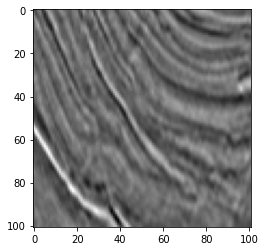

In [11]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(X_train['Image'].iloc[20],cv2.IMREAD_UNCHANGED)
print(img.shape)
plt.imshow(img)

(101, 101)


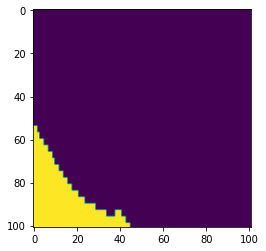

In [12]:
img = cv2.imread(X_train['Mask'].iloc[20],cv2.IMREAD_UNCHANGED)
print(img.shape)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img)

#Segmentation using UNets

In [ ]:
! pip3 install -U segmentation-models

In [ ]:
!pip install tensorflow==2.2.0

In [ ]:
!pip install keras==2.3.1

In [ ]:
# we are importing the pretrained unet from the segmentation models
# https://github.com/qubvel/segmentation_models
%env SM_FRAMEWORK=tf.keras
import tensorflow as tf
import segmentation_models as sm
from segmentation_models import Unet
tf.keras.backend.set_image_data_format('channels_last')

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten,BatchNormalization, ReLU, Reshape , Flatten
from tensorflow.keras.models import Model
import random as rn
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
class Dataset:
    def __init__(self, data_df):
        self.ids = data_df
        # the paths of images
        self.images  = list(data_df['Image'])
        # the paths of mask images
        self.masks    = list(data_df['Mask'])

    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images[i], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image,(512,512),interpolation=cv2.INTER_NEAREST)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image/255.
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        #image = tf.expand_dims(image, axis=-1)
        #print(image.shape)

        mask = cv2.imread(self.masks[i], cv2.IMREAD_UNCHANGED)
        mask = cv2.normalize(mask, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        mask = cv2.resize(mask,(512,512),interpolation= cv2.INTER_NEAREST)
        #mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        #mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask/255.
        mask = tf.expand_dims(mask, axis=-1)
        
        #print(mask.shape)
        return image,mask

    def __len__(self):
        return len(self.ids)
      

In [ ]:
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset,batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
model = Unet('resnet18', encoder_weights='imagenet', classes=1,encoder_freeze=True, activation='sigmoid', input_shape=(512,512,3))

In [ ]:
# https://github.com/qubvel/segmentation_models
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet
optim = tf.keras.optimizers.Adam(0.001)

focal_loss = sm.losses.cce_dice_loss

model.compile(optim, focal_loss, metrics=[iou_score])

In [ ]:
# Dataset for train images
train_dataset = Dataset(X_train)
test_dataset  = Dataset(X_val)

batch_size=16
train_dataloader = Dataloder(train_dataset, batch_size, shuffle=True)
test_dataloader = Dataloder(test_dataset,batch_size, shuffle=True)

print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)

(16, 512, 512, 3)
(16, 512, 512, 1)


In [ ]:
train_dataloader[0][1]

In [ ]:
history = model.fit(train_dataloader, epochs=20, validation_data=test_dataloader)

Epoch 1/20
212/212 [==============================] - 305s 1s/step - loss: 0.3025 - iou_score: 0.5531 - val_loss: 0.8460 - val_iou_score: 0.0836
Epoch 2/20
212/212 [==============================] - 301s 1s/step - loss: 0.2075 - iou_score: 0.6687 - val_loss: 0.8098 - val_iou_score: 0.1057
Epoch 3/20
212/212 [==============================] - 301s 1s/step - loss: 0.1827 - iou_score: 0.7024 - val_loss: 0.8628 - val_iou_score: 0.0773
Epoch 4/20
212/212 [==============================] - 300s 1s/step - loss: 0.1707 - iou_score: 0.7192 - val_loss: 0.7849 - val_iou_score: 0.1271
Epoch 5/20
212/212 [==============================] - 300s 1s/step - loss: 0.1584 - iou_score: 0.7367 - val_loss: 0.7065 - val_iou_score: 0.1800
Epoch 6/20
212/212 [==============================] - 300s 1s/step - loss: 0.1523 - iou_score: 0.7455 - val_loss: 0.1699 - val_iou_score: 0.7184
Epoch 7/20
212/212 [==============================] - 300s 1s/step - loss: 0.1434 - iou_score: 0.7586 - val_loss: 0.1941 - val_iou

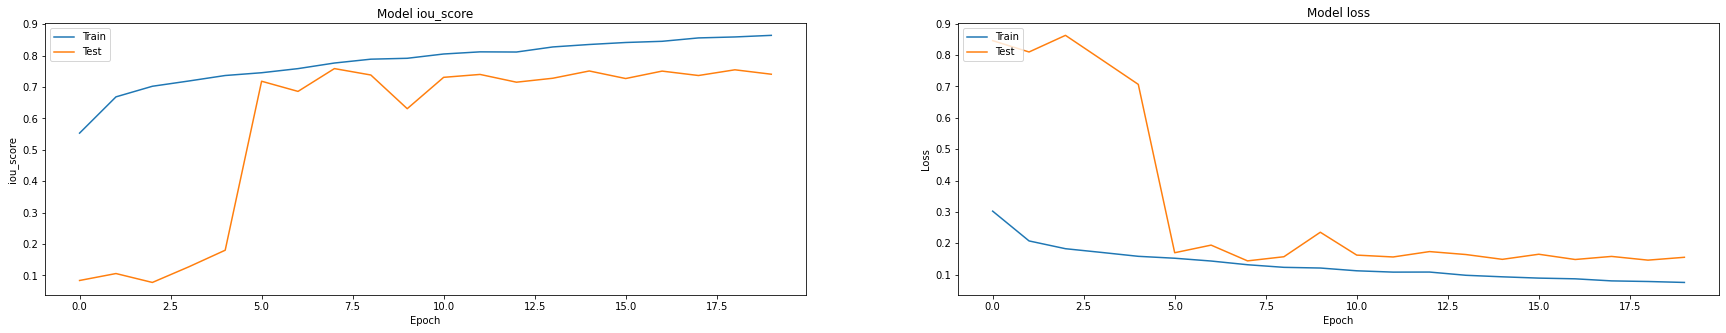

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model.save('model')

In [21]:
!wget --header="Host: doc-04-ak-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/93.0.4577.82 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_prlrdbfrg3otg4unlpgapum7n1nfso0q_nonce=8toqmee00lo60" --header="Connection: keep-alive" "https://doc-04-ak-docs.googleusercontent.com/docs/securesc/p3ptbe8rlut5ek835lgc0qajqm718fu3/lndo87m2j41j1ui1kp9p42stoqofgtj4/1632916200000/00492077336967178142/00492077336967178142/1ofgHVug2zQQb9GSnJoqH5g64pLOtyRlE?e=download&authuser=0&nonce=8toqmee00lo60&user=00492077336967178142&hash=jno0tmmc5u9bme669eu0ju95lip6e22f" -c -O 'model.h5'

--2021-09-29 11:51:17--  https://doc-04-ak-docs.googleusercontent.com/docs/securesc/p3ptbe8rlut5ek835lgc0qajqm718fu3/lndo87m2j41j1ui1kp9p42stoqofgtj4/1632916200000/00492077336967178142/00492077336967178142/1ofgHVug2zQQb9GSnJoqH5g64pLOtyRlE?e=download&authuser=0&nonce=8toqmee00lo60&user=00492077336967178142&hash=jno0tmmc5u9bme669eu0ju95lip6e22f
Resolving doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)... 108.177.120.132, 2607:f8b0:4001:c18::84
Connecting to doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)|108.177.120.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘model.h5’

model.h5                [    <=>             ]  79.26M   117MB/s    in 0.7s    

2021-09-29 11:51:18 (117 MB/s) - ‘model.h5’ saved [83114784]



In [23]:
import tensorflow as tf
model = tf.keras.models.load_model('/content/model.h5', compile=False)

##Predicitons on validation data

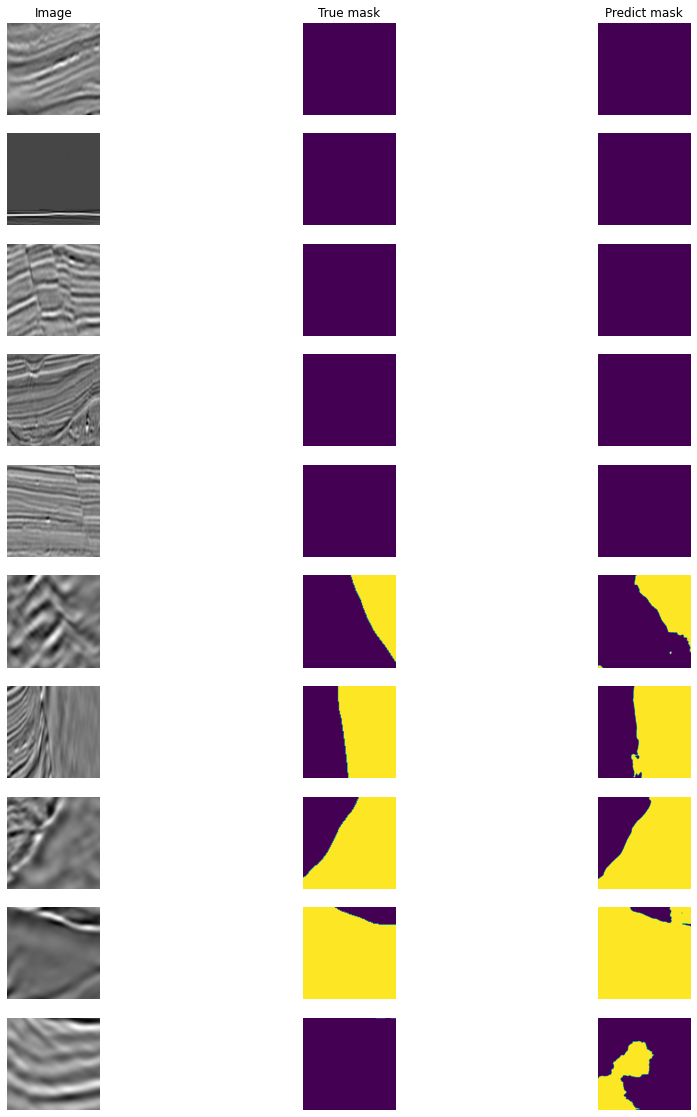

In [ ]:
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(15, 20))
axes[0][0].set_title('Image', size='large')
axes[0][1].set_title('True mask', size='large')
axes[0][2].set_title('Predict mask', size='large')
for i in range (10):
  x_val = test_dataloader[0][0][i]

  y_val = test_dataloader[0][1][i]
  y_val = np.squeeze(y_val,axis=-1)

  y_pred = model.predict(x_val[np.newaxis,:,:,:])
  y_pred = np.squeeze(y_pred,axis=-1)


  # Image
  axes[i][0].axis('off')
  axes[i][0].imshow(x_val)

  # True mask
  axes[i][1].axis('off')
  axes[i][1].imshow(y_val)

   # Predict mask
  axes[i][2].axis('off')
  axes[i][2].imshow(np.round(y_pred[0]))
  

##Predictions on test data

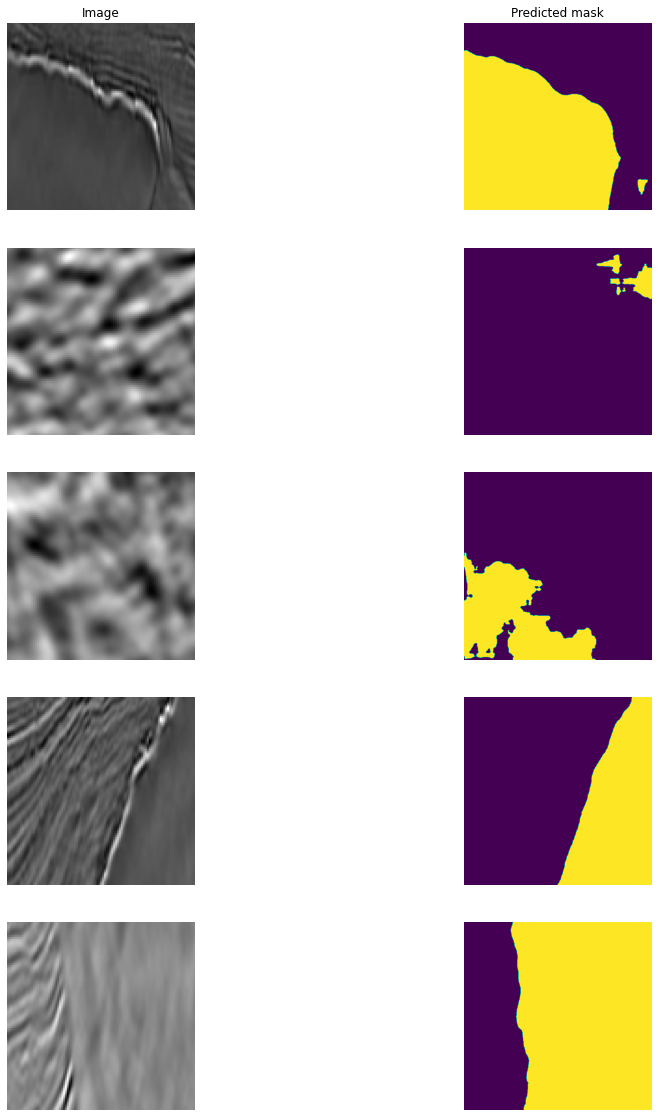

In [ ]:
import random
r = random.sample(range(1,17999),5)
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
axes[0][0].set_title('Image', size='large')
axes[0][1].set_title('Predicted mask', size='large')
for i in range(len(r)):
  # Image
  test_img = cv2.imread(test_images[r[i]])
  test_img = cv2.resize(test_img,(512,512),interpolation=cv2.INTER_NEAREST)
  test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
  test_img = test_img/255.
  axes[i][0].axis('off')
  axes[i][0].imshow(test_img)

  # Predict mask
  y_pred  = model.predict(test_img[np.newaxis,:,:,:])
  y_pred = np.squeeze(y_pred,axis=-1)
  axes[i][1].axis('off')
  axes[i][1].imshow(np.round(y_pred[0])) 




In [ ]:
def mask2rle(mask):
    pixels = mask.flatten(order='F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [13]:
import pandas as pd
test_df = pd.read_csv('/content/competition_data/sample_submission.csv')
test_df

,id,rle_mask
0,3e06571ef3,1 1
1,a51b08d882,1 1
2,c32590b06f,1 1
3,15f7a047c7,1 1
4,e8827bc832,1 1
...,...,...
17995,f7b9f874cb,1 1
17996,26943026b5,1 1
17997,a5050ea371,1 1
17998,7d596c01eb,1 1


In [32]:
file = os.listdir('/content/competition_data/test/images')
test_images=[]
for i in range(len(test_df)):
  test_images.append('/content/competition_data/test/images/'+test_df['id'].iloc[i]+'.png')


In [ ]:
pred_test=[]
for i in range(len(test_images)):
  # Image
  test_img = cv2.imread(test_images[i])
  test_img = cv2.resize(test_img,(512,512),interpolation=cv2.INTER_NEAREST)
  test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
  test_img = test_img/255.

  # Predict mask
  y_pred  = model.predict(test_img[np.newaxis,:,:,:])
  y_pred = np.squeeze(y_pred,axis=-1)
  pred_test.append(y_pred)


In [35]:
rle_masks = [mask2rle(np.round(x[0])) for x in pred_test]